# House Prices: Advanced Regression Techniques

### Description of the dataset
The data has been split into two groups:
- training set (train.csv) : SalePrice(response variable) with 79 explanatory variables
- test set (test.csv)

For detailed data description, check https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

### The Objective
My goal is to predict the final price of each home using (almost) every aspect of residential homes in Ames, Iowa.

# Table of Contents
### [1. Data Preparation for Modeling](#Data-Preparation-for-Modeling)
- [Numerical Variables](#Numerical-Variables)
    * [Check Skewness and Log1 Transformation](#Check-Skewness-and-Log1-Transformation)
- [Categorical Variables](#Categorical-Variables)
    * [Create Dummies for Categorical Variables](#Create-Dummies-for-Categorical-Variables)
    * [Removing Levels with Few or No Observations](#Removing-Levels-with-Few-or-No-Observations)
- [Response Variable](#Response-Variable)
    * [Check Skewness and Log Transformation](#Check-Skewness-and-Log-Transformation)
    
### [2. Modeling](#Modeling)
- [Lasso Regression Model](#Lasso-Regression-Model)
    * [Parameter Tuning](#Parameter-Tuning)
- [Random Forest](#Random-Forest)
- [Averaging Two Models](#Averaging-Two-Models)

In [1]:
%matplotlib inline  
%config InlineBackend.figure_format='retina'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# Import Dataset
train_set = pd.read_csv('new_train.csv')
test_set = pd.read_csv('new_test.csv')

In [3]:
train_set.shape,test_set.shape

((1460, 69), (1459, 68))

In [4]:
# Save 'Id' column
train_ID, test_ID = train_set['Id'], test_set['Id']

# Dropping 'Id' colum since it's unnecessary at the moment
train_set.drop("Id", axis = 1, inplace = True)
test_set.drop("Id", axis = 1, inplace = True)

In [5]:
ntrain = len(train_set)

# store response variable
y_train = train_set.SalePrice

# combining training and testing dataset
combined = pd.concat([train_set, test_set]).drop(['SalePrice'], axis=1).reset_index(drop=True)

print('Dimension of combined dataset is {}'.format(combined.shape))

Dimension of combined dataset is (2919, 67)


As I mentioned in the previous notebook, `GrLivArea` and `TotalBsmtSF` are merely sums of other variables. But I am not sure if it is necessary to drop those yet. So, I will try in both ways and choose one with better performance. 

In [6]:
#combined.drop(['2ndFlrSF','LowQualFinSF'], axis = 1, inplace = True)
#combined.drop(['BsmtFinSF1','BsmtUnfSF','BsmtFinSF2'], axis = 1, inplace = True)

In [7]:
NumOrdVar, cateVar = [], []
for i in combined.columns:
    if combined.loc[:,i].dtype == 'object':
        cateVar.append(i)
    else:
        NumOrdVar.append(i)

print('There are {} Categorical Variables'.format(len(cateVar)))
print('There are {} Numerical or Ordinal Variables'.format(len(NumOrdVar)))

There are 22 Categorical Variables
There are 45 Numerical or Ordinal Variables


# Data Preparation for Modeling
________
## Numerical and Ordinal Variables
### Check Skewness and Log1 Transformation

In [8]:
for i in NumOrdVar:
    if abs(combined.loc[:,i].skew()) > 1:
        combined.loc[:, i] = combined.loc[:, i].apply(lambda x: np.log(x + 1))
    
NumOrdDf = combined[NumOrdVar]

In [9]:
NumOrdDf.shape

(2919, 45)

## Categorical Variables
________

### Create Dummies for Categorical Variables

In [10]:
def createDummies(data):
    df = data
    for i in cateVar:
        dummy = pd.get_dummies(combined.loc[:,i], prefix = i, drop_first = True)
        df = pd.concat([df, dummy], axis = 1)
        df.drop(i, axis = 1, inplace = True)
    return df

In [11]:
cateDf = createDummies(combined[cateVar])

In [12]:
cateDf.shape

(2919, 123)

### Removing Levels with Few or No Observations

In [13]:
# Identify levels with few or no observations train set and drop
fewNoObsVar_train = cateDf.columns[cateDf[:ntrain].apply(sum, axis = 0) < 10]
cateDf.drop(fewNoObsVar_train, axis = 1, inplace = True)

# Same thing for test set
fewNoObsVar_test = cateDf.columns[cateDf[ntrain:].apply(sum, axis = 0) < 10]
cateDf.drop(fewNoObsVar_test, axis = 1, inplace = True)

In [14]:
cateDf.shape

(2919, 74)

In [15]:
combined = pd.concat([NumOrdDf, cateDf], axis = 1)
combined.shape

(2919, 119)

## Response Variable
________
### Check Skewness and Log Transformation

In [16]:
# check Skewness
y_train.skew()

1.8828757597682129

In [17]:
# Log Transformation
log_y_train = np.log(y_train)

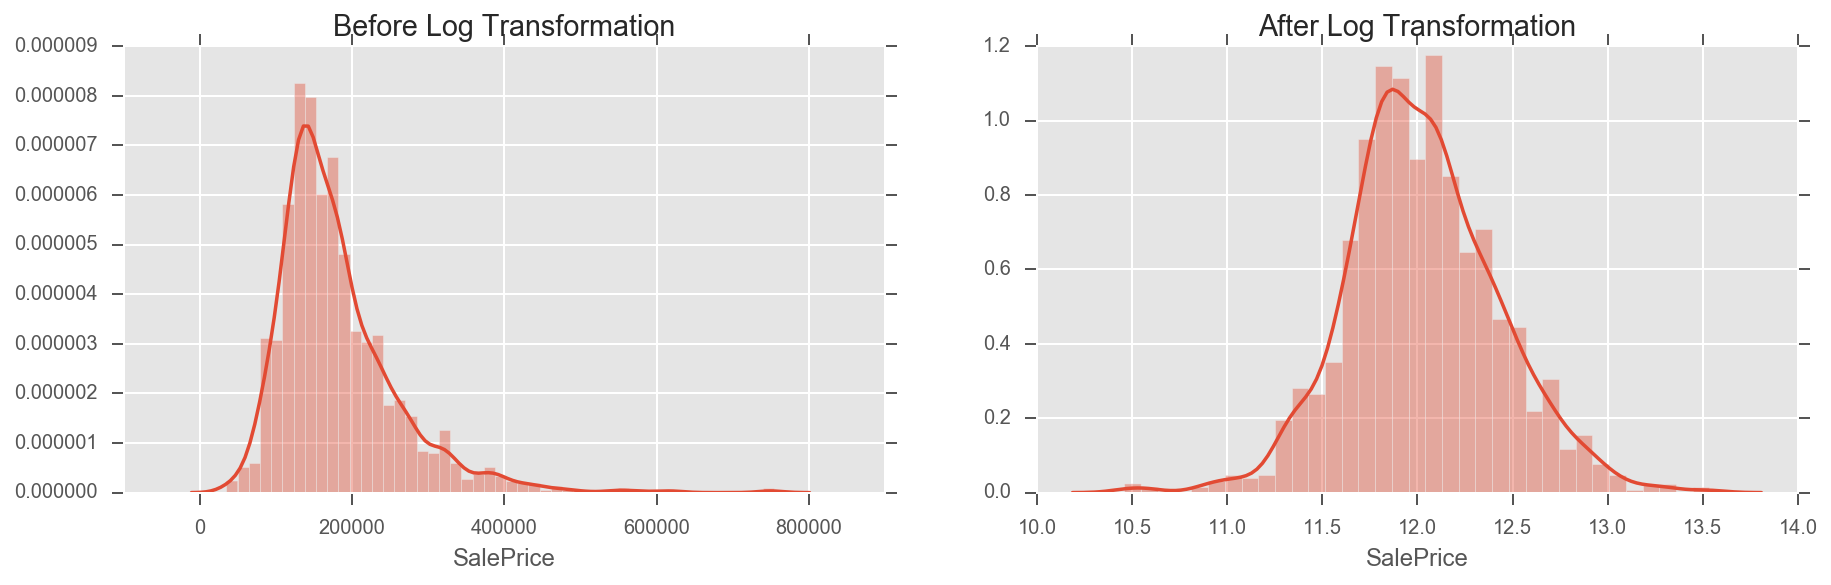

In [18]:
fig, ax = plt.subplots(figsize = (15,4))

plt.subplot(1,2,1)
sns.distplot(y_train)
plt.title('Before Log Transformation')
plt.subplot(1,2,2)
sns.distplot(log_y_train)
plt.title('After Log Transformation')
plt.show()

### Recover Train and Test sets

In [19]:
train_set = combined[:ntrain]
train_set = pd.concat([train_set, log_y_train], axis = 1)
        
test_set = combined[ntrain:].reset_index(drop=True)

# Modeling

In [20]:
from sklearn.model_selection import train_test_split
X, y = train_set.drop('SalePrice', axis = 1), train_set.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

## Lasso Regression Model 
> RMSE = 0.12987

In [21]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
lasso = Lasso()
lasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [22]:
y_pred = lasso.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE of Lasso regression model on test set: {:.4f}'.format(rmse))

RMSE of Lasso regression model on test set: 0.2769


### Parameter Tuning

In [23]:
from sklearn.model_selection import GridSearchCV

parameter_grid = [{'tol' : np.arange(0.001, 1, 0.001), 'alpha' : [0.001,0.01, 0.1, 1]}]

grid_search = GridSearchCV(estimator = Lasso(), param_grid = parameter_grid, cv = 5, scoring = 'neg_mean_squared_error')

In [24]:
lasso = grid_search.fit(X_train, y_train)
print('Best score: {:.4f}'.format(np.sqrt(-lasso.score(X_train, y_train))))
print('Test score: {:.4f}'.format(np.sqrt(-lasso.score(X_test, y_test))))
print('Best parameters: {}'.format(lasso.best_params_))

Best score: 0.1185
Test score: 0.1366
Best parameters: {'tol': 0.044999999999999998, 'alpha': 0.001}


In [25]:
SalePrice = pd.DataFrame(lasso.predict(test_set))
submission = pd.concat([test_ID, np.exp(SalePrice)], axis = 1).rename(columns = {0 : 'SalePrice'})
submission.to_csv('Submission(Lasso).csv', index = False)

## Random Forest
> RMSE = 0.14650

In [26]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [27]:
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE of Lasso regression model on test set: {:.4f}'.format(rmse))

RMSE of Lasso regression model on test set: 0.1432


### Parameter Tuning

In [28]:
from sklearn.model_selection import GridSearchCV
parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [500, 700],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_leaf': [1, 3, 5],
                 'bootstrap': [True, False],
                 }

grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid= parameter_grid, scoring = 'neg_mean_squared_error')

In [29]:
rf = grid_search.fit(X_train, y_train)
print('Best score: {:.4f}'.format(np.sqrt(-rf.score(X_train, y_train))))
print('Test score: {:.4f}'.format(np.sqrt(-rf.score(X_test, y_test))))
print('Best parameters: {}'.format(rf.best_params_))

Best score: 0.0760
Test score: 0.1300
Best parameters: {'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 700, 'min_samples_leaf': 1}


In [30]:
SalePrice = pd.DataFrame(rf.predict(test_set))
submission = pd.concat([test_ID, np.exp(SalePrice)], axis = 1).rename(columns = {0 : 'SalePrice'})
submission.to_csv('Submission(RandomForest).csv', index = False)

## Averaging Two Models
> RMSE = 0.13202

In [31]:
SalePrice = pd.DataFrame((0.2*np.exp(rf.predict(test_set)) + 0.8*np.exp(lasso.predict(test_set)))/2)
submission = pd.concat([test_ID, SalePrice], axis = 1).rename(columns = {0 : 'SalePrice'})
submission.to_csv('Submission(mix).csv', index = False)